# notebooks/02_model_training.ipynb
# 1 - Prototypage des modèles de recommandation
## 1.1 - Imports & configuration
- Chargement des bibliothèques et configuration du notebook

In [1]:
import os
import sys
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from matplotlib import rcParams
import importlib
from dotenv import load_dotenv

In [2]:
# Détermine dynamiquement le chemin racine du projet depuis le notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # remonte depuis notebooks/

# Chemin absolu vers le dossier src/
src_path = os.path.join(project_root, "src")

# Ajout au sys.path s'il n'y est pas déjà
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Projet racine : {project_root}")
print(f"Dossier src ajoute : {src_path}")

Projet racine : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python
Dossier src ajoute : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\src


In [3]:
# CHARGEMENT OBLIGATOIRE des variables d'environnement
env_file = os.path.join(project_root, ".env.prod")
if os.path.exists(env_file):
    load_dotenv(env_file)
    print(f"Variables d'environnement chargees depuis : {env_file}")
    azure_conn = os.getenv("AZURE_CONN_STR")
    if azure_conn and "fresh2025" in azure_conn:
        print("Configuration Azure a jour (fresh2025)")
    else:
        print("ATTENTION: Configuration Azure obsolete ou manquante")
else:
    print(f"ERREUR: fichier .env.prod non trouve : {env_file}")

Variables d'environnement chargees depuis : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\.env.prod
Configuration Azure a jour (fresh2025)


In [4]:
try:
    from loaders import load_df, load_metadata, load_embeddings, load_cf_model
    from data_preprocessing import load_article_embeddings
    from recommendation_engine import get_cbf_recommendations, get_cf_recommendations, get_hybrid_recommendations, get_recommendations
    from model_training import train_cf_model
    from utils.validators import check_column_presence
    from visuals.interactive_alpha import update_recommendations
    from wrappers import get_recommendations_from_user
    print("Tous les modules importes avec succes")
except ImportError as e:
    print(f"Erreur import module : {e}")

src/ ajouté à sys.path : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\src
Tous les modules importes avec succes


In [5]:
# Chargement des donnees 
azure_conn = os.getenv("AZURE_CONN_STR")

if azure_conn:
    print("Tentative de chargement depuis Azure (conteneur: artefacts-fresh)...")
    try:
        # CORRECTION: utilise le bon nom de conteneur
        df = load_df(source="azure", 
                     filename="df_light.parquet", 
                     container_name="artefacts-fresh",  # CORRIGÉ
                     connection_string=azure_conn)
        print(f"Donnees Azure chargees avec succes : {len(df)} lignes")
        data_source = "azure"
    except Exception as e:
        print(f"Erreur chargement Azure : {e}")
        print("Fallback vers le mode local...")
        try:
            df = load_df(source="local", filename="df_light.parquet")
            print(f"Donnees locales chargees : {len(df)} lignes")
            data_source = "local"
        except Exception as e2:
            print(f"Erreur chargement local : {e2}")
            data_source = "error"
else:
    print("AZURE_CONN_STR non disponible, chargement en local...")
    try:
        df = load_df(source="local", filename="df_light.parquet")
        print(f"Donnees locales chargees : {len(df)} lignes")
        data_source = "local"
    except Exception as e:
        print(f"Erreur chargement local : {e}")
        data_source = "error"

print(f"Source des donnees : {data_source}")

Tentative de chargement depuis Azure (conteneur: artefacts-fresh)...
Donnees Azure chargees avec succes : 10342 lignes
Source des donnees : azure


In [6]:
# Imports des fonctions de traitement

from data_preprocessing import load_article_embeddings
from recommendation_engine import get_cbf_recommendations, get_cf_recommendations, get_hybrid_recommendations, get_recommendations
from model_training import train_cf_model
from utils.validators import check_column_presence
from visuals.interactive_alpha import update_recommendations
from loaders import load_df

## 1.2 - Chargement des données (df principal et embeddings)

In [7]:
# Chargement du DataFrame interactions nettoyé
df_path = os.path.join(project_root, "outputs", "df_light.parquet")
df = pd.read_parquet(df_path)

In [8]:
# Vérification des colonnes nécessaires
required_cols = ["user_id", "article_id"]
check_column_presence(df, required_cols, "df")

In [9]:
# Chargement des embeddings compressés + mapping {article_id: index}
df_articles_path = os.path.join(project_root, "outputs", "df_articles.parquet")
embeddings, article_id_to_index = load_article_embeddings(df_articles_path)

In [10]:
# Chargement du DataFrame enrichi des articles pour affichage (métadonnées)
df_articles = pd.read_parquet(df_articles_path)

## 1.3 - Recommandation Content-Based Filtering (CBF)

### 1.3.1 - Description du modèle
- Le modèle Content-Based Filtering recommande des articles similaires à ceux que l'utilisateur a déjà consultés, en s'appuyant sur les embeddings d'articles.
- La logique repose sur :
    - la récupération des articles consultés par l'utilisateur,
    - la moyenne de leurs vecteurs (profil utilisateur),
    - la recherche des articles les plus similaires (cosine similarity),
    - l'exclusion des articles déjà vus.

| Ce que c’est                                                                 | Ce que ça prouve                                                                 |
|------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| Recommande des articles similaires à ceux déjà cliqués                      | Le système peut fonctionner même sans données d’autres utilisateurs             |
| Basé sur les embeddings d’articles                                           | Les contenus eux-mêmes suffisent à générer des suggestions pertinentes          |
| Rapide, autonome                                                             | Ne dépend pas des autres utilisateurs → parfait pour les nouveaux articles      |
| ❌ Ne peut pas recommander des articles très différents de l’historique      | ❌ Peu de capacité à explorer de nouveaux types de contenus                      |


### 1.3.2 - Sélection d’un utilisateur test
- On sélectionne un user_id existant ayant consulté au moins un article

In [11]:
user_id_test = df["user_id"].value_counts().index[0]
print(f"Exemple d'utilisateur testé : {user_id_test}")

Exemple d'utilisateur testé : 10421


### 1.3.3 - Génération de recommandations CBF
- Appel à la fonction get_cbf_recommendations()

In [12]:
top_n = 5
reco_article_ids = get_cbf_recommendations(user_id = user_id_test,
                                           df = df,
                                           embeddings = embeddings,
                                           article_id_to_index = article_id_to_index,
                                           top_n = top_n)

In [13]:
print(f"Top {top_n} articles recommandés pour l'utilisateur {user_id_test} :")
print(reco_article_ids)

Top 5 articles recommandés pour l'utilisateur 10421 :
[202135, 202114, 202124, 202178, 202162]


### 1.3.4 - Affichage lisible des recommandations CBF

In [14]:
# Filtrage sur les articles recommandés
df_recommendations = df_articles[df_articles["article_id"].isin(reco_article_ids)]
df_recommendations = df_recommendations.sort_values(by = ["category_id", "created_at_ts"])

In [15]:
# Affichage des colonnes disponibles pour évaluer les recommandations
print("Aperçu des articles recommandés (CBF) :")
display(df_recommendations[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])

Aperçu des articles recommandés (CBF) :


,article_id,category_id,publisher_id,words_count,created_at_ts
202124,202124,327,0,156,1511277949000
202114,202114,327,0,166,1511365846000
202135,202135,327,0,133,1511806517000
202162,202162,327,0,116,1512767316000
202178,202178,327,0,216,1513241172000


## 1.4 - Recommandation Collaborative Filtering (CF)

| Ce que c’est                                                                     | Ce que ça prouve                                                             |
|----------------------------------------------------------------------------------|------------------------------------------------------------------------------|
| Recommande des articles consultés par des utilisateurs similaires               | Le système apprend des comportements collectifs                             |
| Basé sur matrice user-article (SVD ici)                                          | La communauté renforce la personnalisation                                  |
| ❌ Nécessite beaucoup d’interactions historiques                                 | ❌ Moins performant pour les nouveaux utilisateurs ou articles inconnus      |


### 1.4.1 - Entraînement ou chargement du modèle CF

In [16]:
# Rechargement des métadonnées articles si besoin (sinon utiliser df_articles déjà chargé)
model_cf = train_cf_model(df = df,
                          model_path = os.path.join(project_root, "models", "model_cf.pkl"),
                          force_retrain = False)

Chargement du modèle CF existant depuis : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\models\model_cf.pkl


In [17]:
model_path = os.path.join(project_root, "models", "model_cf.pkl")
# force_retrain = not os.path.exists(model_path)  # ou True si besoin
force_retrain = False
model_cf = train_cf_model(df, model_path=model_path, force_retrain=force_retrain)

Chargement du modèle CF existant depuis : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\models\model_cf.pkl


### 1.4.2 - Génération de recommandations CF

In [18]:
reco_cf_ids = get_cf_recommendations(user_id = user_id_test,
                                     df = df,
                                     model = model_cf,
                                     top_n = top_n)

In [19]:
print(f"Top {top_n} articles recommandés pour l'utilisateur {user_id_test} (CF) :")
print(reco_cf_ids)

Top 5 articles recommandés pour l'utilisateur 10421 (CF) :
[236682, 106819, 233769, 28820, 297051]


### 1.4.3 - Affichage lisible des recommandations CF

In [20]:
df_reco_cf = df_articles[df_articles["article_id"].isin(reco_cf_ids)]
df_reco_cf = df_reco_cf.sort_values(by = ["category_id", "created_at_ts"])

In [21]:
print("Aperçu des articles recommandés (CF) :")
display(df_reco_cf[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])

Aperçu des articles recommandés (CF) :


,article_id,category_id,publisher_id,words_count,created_at_ts
28820,28820,26,0,311,1482328680000
106819,106819,228,0,112,1506805304000
236682,236682,375,0,166,1506787390000
233769,233769,375,0,228,1506800709000
297051,297051,428,0,184,1482161900000


## 1.5 - Comparaison Content-Based vs Collaborative Filtering

In [22]:
print("Comparaison des articles recommandés pour l'utilisateur", user_id_test)

Comparaison des articles recommandés pour l'utilisateur 10421


In [23]:
# Préparation des deux tableaux triés
df_cbf_sorted = df_recommendations.sort_values(by = ["category_id", "created_at_ts"])
df_cf_sorted  = df_reco_cf.sort_values(by = ["category_id", "created_at_ts"])

In [24]:
print("\nArticles recommandés par le modèle CBF :")
display(df_cbf_sorted[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])


Articles recommandés par le modèle CBF :


,article_id,category_id,publisher_id,words_count,created_at_ts
202124,202124,327,0,156,1511277949000
202114,202114,327,0,166,1511365846000
202135,202135,327,0,133,1511806517000
202162,202162,327,0,116,1512767316000
202178,202178,327,0,216,1513241172000


In [25]:
print("\nArticles recommandés par le modèle CF :")
display(df_cf_sorted[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])


Articles recommandés par le modèle CF :


,article_id,category_id,publisher_id,words_count,created_at_ts
28820,28820,26,0,311,1482328680000
106819,106819,228,0,112,1506805304000
236682,236682,375,0,166,1506787390000
233769,233769,375,0,228,1506800709000
297051,297051,428,0,184,1482161900000


In [26]:
# Résumé croisé des article_id uniquement
comparison_df = pd.DataFrame({
    "CBF_article_id" : reco_article_ids,
    "CF_article_id"  : reco_cf_ids
})

In [27]:
print("\nRésumé comparatif des article_id recommandés (CBF vs CF) :")
display(comparison_df)


Résumé comparatif des article_id recommandés (CBF vs CF) :


,CBF_article_id,CF_article_id
0,202135,236682
1,202114,106819
2,202124,233769
3,202178,28820
4,202162,297051


# 1.6.1 - Temps de calcul (benchmark)

In [28]:
start_cbf = time.perf_counter()
get_cbf_recommendations(user_id_test, df, embeddings, article_id_to_index, top_n)
elapsed_cbf = time.perf_counter() - start_cbf

In [29]:
start_cf = time.perf_counter()
get_cf_recommendations(user_id_test, df, model_cf, top_n)
elapsed_cf = time.perf_counter() - start_cf

In [30]:
print(f"Temps de calcul CBF : {elapsed_cbf:.4f} s")
print(f"Temps de calcul CF  : {elapsed_cf:.4f} s")

Temps de calcul CBF : 0.1276 s
Temps de calcul CF  : 0.0156 s


# 1.6.2 - Taux d'overlap (articles recommandés à la fois en CBF et CF)

In [31]:
overlap = set(reco_article_ids).intersection(set(reco_cf_ids))
overlap_ratio = len(overlap) / top_n

In [32]:
print(f"Articles en commun (overlap) : {overlap}")
print(f"Taux d’overlap CBF vs CF : {overlap_ratio:.2%}")

Articles en commun (overlap) : set()
Taux d’overlap CBF vs CF : 0.00%


- On observe ici un taux d’overlap nul entre CBF et CF. 
    - Cela montre que les deux moteurs exploitent des logiques différentes et potentiellement complémentaires.
    - Le CBF est focalisé sur la similarité de contenu, tandis que le CF se base sur les comportements d’autres utilisateurs. 
    - Cela ouvre la voie à une stratégie hybride permettant de combiner pertinence et diversité. »
# 1.6.3 - Distribution par catégorie des recommandations

In [33]:
cat_cbf = df_recommendations["category_id"].value_counts().sort_index()
cat_cf  = df_reco_cf["category_id"].value_counts().sort_index()

In [34]:
comparison_df = pd.DataFrame({
    "CBF" : cat_cbf,
    "CF"  : cat_cf
}).fillna(0).astype(int)

In [35]:
print("Distribution des catégories dans les recommandations :")
display(comparison_df)

Distribution des catégories dans les recommandations :


,CBF,CF
category_id,,
26,0,1
228,0,1
327,5,0
375,0,2
428,0,1


# 1.6.4 - Visualisation

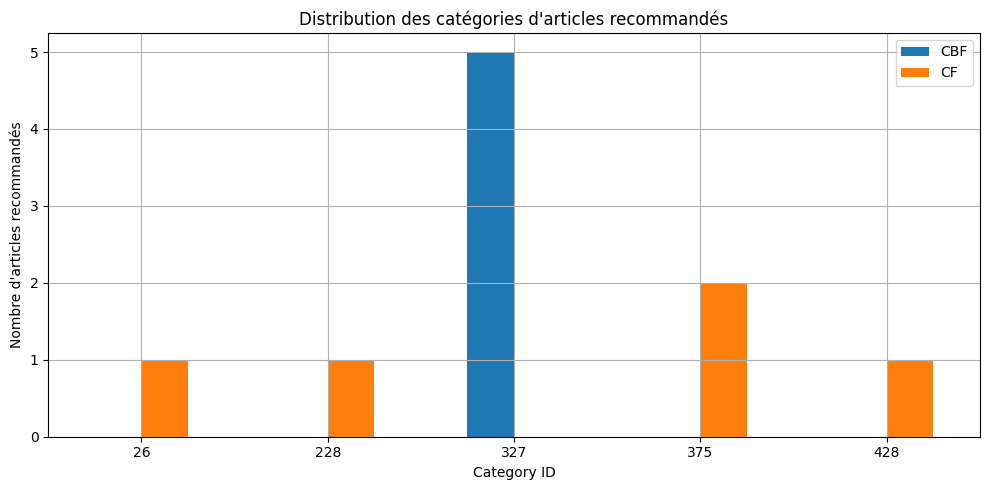

In [36]:
comparison_df.plot(kind = "bar", figsize = (10, 5))
plt.title("Distribution des catégories d'articles recommandés")
plt.xlabel("Category ID")
plt.ylabel("Nombre d'articles recommandés")
plt.xticks(rotation = 0)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.7 - Recommandations hybrides CBF + CF

| Ce que c’est                                                                                     | Ce que ça prouve                                                              |
|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| Combine les deux approches avec un poids `alpha` ajustable                                       | Capacité à équilibrer contenu et communauté                                  |
| Permet une personnalisation plus robuste et plus variée                                          | Montre que l'on maîtrises l’assemblage de techniques ML                    |
| `alpha = 0.0` → CF pur ; `alpha = 1.0` → CBF pur ; entre deux → fusion intelligente              | Flexibilité du système selon les profils utilisateurs      

In [37]:
reco_hybrid_ids = get_hybrid_recommendations(user_id = user_id_test,
                                             df = df,
                                             embeddings = embeddings,
                                             article_id_to_index = article_id_to_index,
                                             model_cf = model_cf,
                                             top_n = 5,
                                             alpha = 0.5)  # 0.5 = mix équilibré

In [38]:
df_reco_hybrid = df_articles[df_articles["article_id"].isin(reco_hybrid_ids)]
df_reco_hybrid = df_reco_hybrid.sort_values(by = ["category_id", "created_at_ts"])

In [39]:
print("Aperçu des articles recommandés (Hybride CBF + CF) :")
display(df_reco_hybrid[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])

Aperçu des articles recommandés (Hybride CBF + CF) :


,article_id,category_id,publisher_id,words_count,created_at_ts
58664,58664,118,0,247,1507232155000
202676,202676,327,0,197,1507154338000
202388,202388,327,0,305,1507723340000
203454,203454,327,0,197,1508143318000
205845,205845,331,0,256,1508084126000


### 1.7.1 - Visualisation de la répartition des sources

In [40]:
# Récupèration de tous les article_id recommandés pour les 3 méthodes
set_cbf     = set(reco_article_ids)
set_cf      = set(reco_cf_ids)
set_hybrid  = set(reco_hybrid_ids)

In [41]:
# Catégorisation des recommandations hybrides
hybrid_only     = set_hybrid - set_cbf - set_cf
hybrid_from_cbf = set_hybrid & set_cbf - set_cf
hybrid_from_cf  = set_hybrid & set_cf - set_cbf
hybrid_overlap  = set_hybrid & set_cbf & set_cf

In [42]:
labels = ["Uniquement CBF", "Uniquement CF", "Communs CBF+CF", "Nouveaux (Hybride)"]
sizes = [len(hybrid_from_cbf), len(hybrid_from_cf), len(hybrid_overlap), len(hybrid_only)]

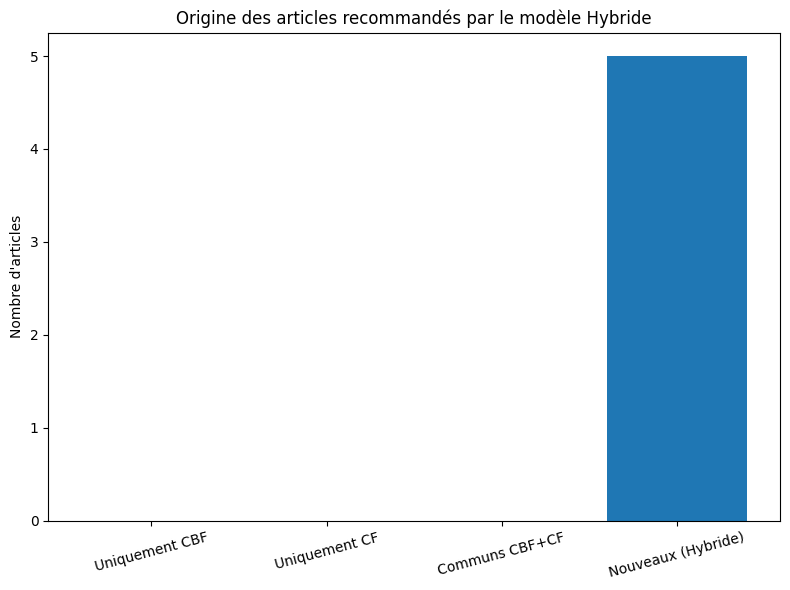

In [43]:
plt.figure(figsize = (8, 6))
plt.bar(labels, sizes)
plt.title("Origine des articles recommandés par le modèle Hybride")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation = 15)
plt.tight_layout()
plt.show()

- le modèle Hybride a proposé 5 articles différents de ceux des deux autres
- il n’a pas réutilisé d’articles CBF ni CF
- donc la fusion pondérée a fait ressortir de nouveaux candidats gagnants (pas présents dans les 2 tops 5 initiaux).
- Conclusion possible : 
    - Il y a un effet de "filtrage croisé" où les scores CBF et CF sont faibles pour les anciens top articles, mais moyennement bons pour d’autres, ce qui les fait passer devant
### 1.7.2 - Impact du paramètre alpha
- alpha est un poids de pondération qui contrôle la balance entre les deux modèles dans la recommandation hybride.
    - Il varie entre 0.0 et 1.0 : 
        - `score_hybride = alpha * score_CBF + (1 - alpha) * score_CF`

### Interprétation par valeur
| alpha | Pondération réelle           | Interprétation                                               |
|-------|------------------------------|--------------------------------------------------------------|
| 0.0   | 0 % CBF + 100 % CF           | L’hybride est identique au CF                                |
| 0.2   | 20 % CBF + 80 % CF           | L’hybride penche fortement côté collaboratif                 |
| 0.5   | 50 % CBF + 50 % CF           | Pondération équilibrée : CBF et CF ont le même poids         |
| 0.8   | 80 % CBF + 20 % CF           | L’hybride favorise le contenu tout en gardant un peu de CF   |
| 1.0   | 100 % CBF + 0 % CF           | L’hybride est identique au CBF       

In [44]:
alphas = [round(a, 2) for a in np.linspace(0, 1, 11)]
overlaps_cbf = []
overlaps_cf = []

In [45]:
for a in alphas:
    hybrid_ids = get_hybrid_recommendations(user_id = user_id_test,
                                            df = df,
                                            embeddings = embeddings,
                                            article_id_to_index = article_id_to_index,
                                            model_cf = model_cf,
                                            top_n = 5,
                                            alpha = a)
    set_hybrid = set(hybrid_ids)
    overlaps_cbf.append(len(set_cbf & set_hybrid) / 5 * 100)
    overlaps_cf.append(len(set_cf & set_hybrid) / 5 * 100)

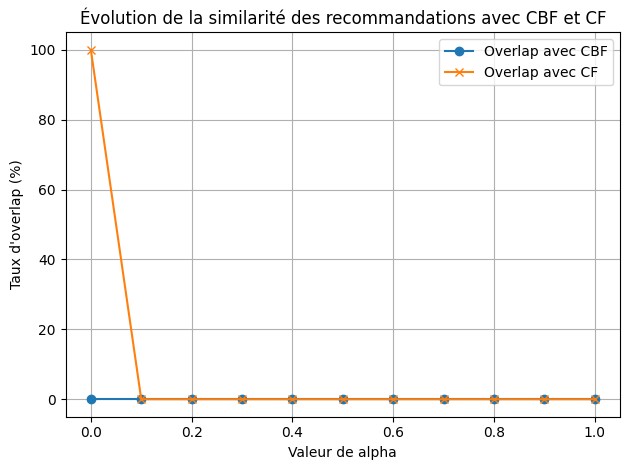

In [46]:
plt.plot(alphas, overlaps_cbf, label = "Overlap avec CBF", marker = "o")
plt.plot(alphas, overlaps_cf, label = "Overlap avec CF", marker = "x")
plt.xlabel("Valeur de alpha")
plt.ylabel("Taux d'overlap (%)")
plt.title("Évolution de la similarité des recommandations avec CBF et CF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.8 – Exploration interactive du paramètre alpha

In [47]:
# Slider alpha de 0.0 à 1.0 avec pas de 0.01
alpha_slider = widgets.FloatSlider(
    value = 0.5,
    min = 0.0,
    max = 1.0,
    step = 0.01,
    description = 'alpha',
    readout_format = '.2f',
    style = {'description_width': 'initial'},
    layout = widgets.Layout(width = '50%')
)

In [48]:
# Zone de sortie
output = widgets.Output()

In [49]:
# Lancement du callback lors du déplacement du slider
alpha_slider.observe(
    lambda change: update_recommendations(change,
                                          user_id = user_id_test,
                                          df = df,
                                          embeddings = embeddings,
                                          article_id_to_index = article_id_to_index,
                                          model_cf = model_cf,
                                          df_articles = df_articles,
                                          output_widget = output,
                                          top_n = 5,
                                          get_hybrid_recommendations_func = get_hybrid_recommendations),
    names = "value"
)


In [50]:
display(alpha_slider, output)

FloatSlider(value=0.5, description='alpha', layout=Layout(width='50%'), max=1.0, step=0.01, style=SliderStyle(…

Output()

In [51]:
# Affichage initial
update_recommendations({"new": alpha_slider.value},
                       user_id = user_id_test,
                       df = df,
                       embeddings = embeddings,
                       article_id_to_index = article_id_to_index,
                       model_cf = model_cf,
                       df_articles = df_articles,
                       output_widget = output,
                       top_n = 5,
                       get_hybrid_recommendations_func = get_hybrid_recommendations)

## 1.9 - Quand utiliser....
### 1.9.1 - Content-Based Filtering (CBF)
| Critère                                         | Choix recommandé : CBF     |
|-------------------------------------------------|-----------------------------|
| Nouveaux utilisateurs                           | Oui (cold start user)       |
| Nouveaux articles                               | Oui (car CF ne les connaît pas encore) |
| Faible historique utilisateur                   | Oui (utilise juste l’historique personnel) |
| Forte diversité d’articles                      | Oui (basé sur le contenu, ex : embeddings) |
| Explicabilité requise                           | Oui (recommandations compréhensibles) |
| Objectif                                        | Renforcer les préférences connues, pas explorer |
### 1.9.2 - Collaborative Filtering (CF)
| Critère                                         | Choix recommandé : CF      |
|-------------------------------------------------|-----------------------------|
| Utilisateurs actifs avec beaucoup d’interactions | Oui                         |
| Beaucoup de données de clics/historiques        | Oui                         |
| Objectif                                        | Découverte via les comportements des autres |
| Système communautaire ou plateforme sociale     | Oui (effet de réseau)       |
| Contenus peu structurés                         | Oui (CF reste performant)   |
| Problème sur articles récents ou utilisateurs récents | Oui (limitation cold start) |
### 1.9.3 - Méthode hybride (CBF + CF)
| Critère                                         | Choix recommandé : Hybride |
|-------------------------------------------------|-----------------------------|
| Besoin de robustesse                            | Oui                         |
| Besoin de personnalisation fine                 | Oui (paramètre alpha)       |
| Objectif                                        | Équilibre entre contenu et comportement |
| Système en production réel                      | Oui                         |
| Mise en valeur technique                        | Oui                         |
### 1.9.4 - Recommandation pratique
| Situation dans le projet P10                        | Méthode suggérée              |
|-----------------------------------------------------|-------------------------------|
| Phase test rapide avec utilisateurs fictifs         | CBF                           |
| Mise en valeur d’un algo en soutenance              | Ajouter CF puis Hybride       |
| Production future                                    | Hybride avec alpha dynamique  |


## 1.10 - Arbre de décision visuel

In [52]:
# Paramètres d'affichage
rcParams.update({"font.size": 9})

In [53]:
# Création du graphe de décision
G = nx.DiGraph()

In [54]:
# Ajout des noeuds et des transitions
G.add_edges_from([
    ("Données disponibles ?", "Oui - Données utilisateurs"),
    ("Données disponibles ?", "Non - Nouveaux utilisateurs/articles"),

    ("Oui - Données utilisateurs", "Beaucoup d'interactions ?"),
    ("Non - Nouveaux utilisateurs/articles", "Utiliser CBF"),

    ("Beaucoup d'interactions ?", "Oui → Utiliser CF"),
    ("Beaucoup d'interactions ?", "Pas trop → Hybride"),

    ("Utiliser CF", "Production : CBF+CF ?"),
    ("CBF", "Production : CBF+CF ?"),

    ("Production : CBF+CF ?", "Oui → Hybride"),
    ("Production : CBF+CF ?", "Non → Rester sur CF ou CBF")
])

In [55]:
# Définition de la position des nœuds (layout hiérarchique approximatif)
pos = nx.spring_layout(G, seed=42, k=1.2)

C:\Users\motar\AppData\Local\Temp\ipykernel_11880\745096176.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


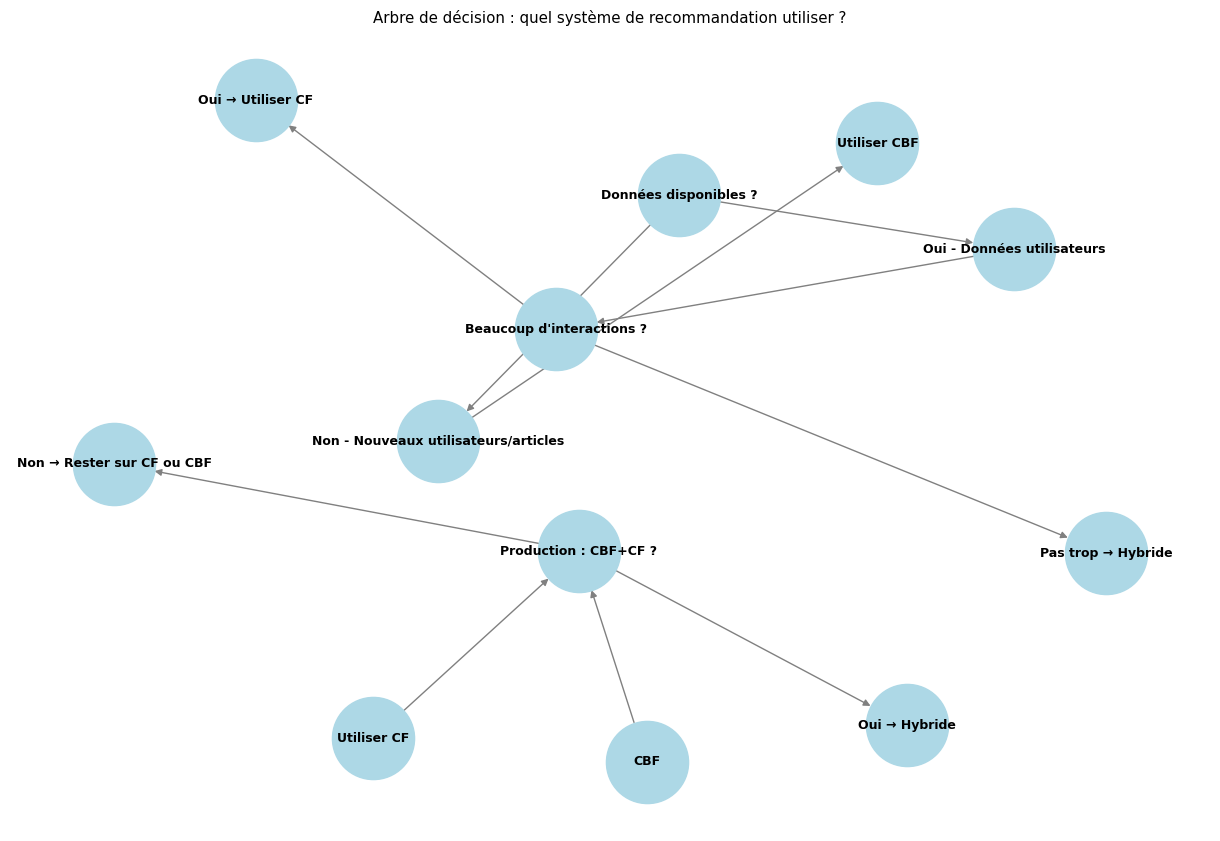

In [56]:
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3500, node_color="lightblue", font_weight="bold", edge_color="gray", font_size=9)
plt.title("Arbre de décision : quel système de recommandation utiliser ?")
plt.tight_layout()
plt.show()

In [57]:
user_id_test = df["user_id"].sample(1).iloc[0]  

reco_ids = get_recommendations(
    user_id = user_id_test,
    df = df,
    model_cf = model_cf,
    embeddings = embeddings,
    article_id_to_index = article_id_to_index,
    mode = "auto",               # ou "cbf", "cf", "hybrid"
    alpha = 0.6,                 # pour hybrid
    user_clicks_threshold = 5,   # seuil de clics à partir duquel on bascule
    top_n = 10                   # nombre d’articles recommandés
)

In [58]:
# Affichage des articles recommandés (si dispo dans df_articles)
df_articles[df_articles["article_id"].isin(reco_ids)][
    ["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]
]

,article_id,category_id,publisher_id,words_count,created_at_ts
64329,64329,134,0,199,1506970055000
154444,154444,281,0,176,1456592168000
159943,159943,281,0,182,1507908296000
160132,160132,281,0,227,1507086884000
161100,161100,281,0,292,1507039341000
162369,162369,281,0,314,1506859458000
166177,166177,289,0,271,1507708954000
166322,166322,289,0,173,1508138644000
285055,285055,412,0,160,1507163821000
357643,357643,450,0,260,1508000421000


df = historique clics (clicks_sample ou fusion complète)

df_articles = métadonnées articles (articles_metadata.csv)

embeddings = embeddings réduits (format .npz ou .pickle)

article_id_to_index = dictionnaire pour retrouver les indices des embeddings

model_cf = modèle CF entraîné (SVD par exemple)

In [59]:
df_articles = pd.read_parquet("../outputs/df_articles.parquet")
print(type(df_articles["embedding"].iloc[0]))  # doit afficher <class 'numpy.ndarray'>

<class 'numpy.ndarray'>


# 2 - Tests
## 2.1 - Test de load_df
Ce bloc vérifie :

Que la connexion Azure fonctionne bien (AZURE_CONN_STR).

Que le fichier df_light.parquet est bien présent dans Azure Blob.

Que le contenu est correctement chargé dans un DataFrame.

Que le résultat est bien exploitable (affichage .shape, .head()).

In [60]:
# Test des recommandations en mode local
print("=== Test recommandations mode LOCAL ===")
try:
    recommended_ids = get_recommendations_from_user(user_id=8, source="local")
    print(f"Articles recommandés : {recommended_ids}")
    print(f"Nombre de recommandations : {len(recommended_ids)}")
except Exception as e:
    print(f"Erreur mode local : {e}")

print("\n=== Test recommandations mode AZURE ===")
try:
    recommended_ids = get_recommendations_from_user(user_id=8, source="azure")
    print(f"Articles recommandés : {recommended_ids}")
    print(f"Nombre de recommandations : {len(recommended_ids)}")
except Exception as e:
    print(f"Erreur mode azure : {e}")

=== Test recommandations mode LOCAL ===
Articles recommandés : [284178, 285741, 280868, 282755, 284184]
Nombre de recommandations : 5

=== Test recommandations mode AZURE ===
Articles recommandés : [284178, 284846, 284845, 284177, 286077]
Nombre de recommandations : 5


In [61]:
try:
    df_from_blob = load_df(source="azure", filename="df_light.parquet")
    print(f"Chargement Azure réussi : {df_from_blob.shape}")
    df_from_blob.head()
except Exception as e:
    print(f"Erreur Azure : {e}")
    print("Utilisation du fichier local...")
    df_from_blob = load_df(source="local", filename="df_light.parquet")
    print(f"Chargement local réussi : {df_from_blob.shape}")
print(df_from_blob.shape)
df_from_blob.head()

Chargement Azure réussi : (10342, 19)
(10342, 19)


,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count,hour,day,month
0,8,1506825573366745,1506825573000,3,332114,2017-10-01 03:03:19.683,4,3,20,1,12,1,436,1506791182000,0,265,3,Sunday,2017-10
1,8,1506825573366745,1506825573000,3,284847,2017-10-01 03:10:38.642,4,3,20,1,12,1,412,1506802073000,0,266,3,Sunday,2017-10
2,8,1506825573366745,1506825573000,3,114161,2017-10-01 03:11:08.642,4,3,20,1,12,1,237,1506799438000,0,154,3,Sunday,2017-10
3,96,1506826575357833,1506826575000,2,145166,2017-10-01 03:04:33.011,4,1,17,1,25,2,269,1506785272000,0,180,3,Sunday,2017-10
4,96,1506826575357833,1506826575000,2,284847,2017-10-01 03:05:03.011,4,1,17,1,25,2,412,1506802073000,0,266,3,Sunday,2017-10


In [62]:
from wrappers import get_recommendations_from_user
get_recommendations_from_user(user_id=8, source="local")

[284178, 285741, 280868, 282755, 284184]

## 2.2 - Séquence de tests fonctionnels – Lecture Azure Blob
### 2.2.1 - Connexion à Azure & lecture de df_light.parquet
Vérifie :

Connexion valide

Présence du blob df_light.parquet

Données exploitables (affichage des colonnes)

In [63]:
from loaders import load_df

df_blob = load_df(source="azure")
print(df_blob.shape)
df_blob.head()

(10342, 19)


,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count,hour,day,month
0,8,1506825573366745,1506825573000,3,332114,2017-10-01 03:03:19.683,4,3,20,1,12,1,436,1506791182000,0,265,3,Sunday,2017-10
1,8,1506825573366745,1506825573000,3,284847,2017-10-01 03:10:38.642,4,3,20,1,12,1,412,1506802073000,0,266,3,Sunday,2017-10
2,8,1506825573366745,1506825573000,3,114161,2017-10-01 03:11:08.642,4,3,20,1,12,1,237,1506799438000,0,154,3,Sunday,2017-10
3,96,1506826575357833,1506826575000,2,145166,2017-10-01 03:04:33.011,4,1,17,1,25,2,269,1506785272000,0,180,3,Sunday,2017-10
4,96,1506826575357833,1506826575000,2,284847,2017-10-01 03:05:03.011,4,1,17,1,25,2,412,1506802073000,0,266,3,Sunday,2017-10


### 2.2.2 - Lecture des embeddings compressés .np
Vérifie :

Connexion valide

Présence de articles_embeddings_compressed.npz

Bonne clé "embeddings" dans le fichier

In [64]:
from dotenv import load_dotenv
load_dotenv()

False

In [65]:
from loaders import load_cf_model

# Test avec les bons paramètres pour Azure
print("=== Test chargement modèle CF AZURE ===")
try:
    model_cf = load_cf_model(source="azure", 
                            filename="model_cf_light.pkl", 
                            container_name="artefacts-fresh")
    print(f"Modèle Azure chargé avec succès : {type(model_cf)}")
except Exception as e:
    print(f"Erreur Azure : {e}")
    print("Tentative en local...")
    try:
        model_cf = load_cf_model(source="local", filename="model_cf.pkl")
        print(f"Modèle local chargé avec succès : {type(model_cf)}")
    except Exception as e2:
        print(f"Erreur locale : {e2}")

print("\n=== Test chargement modèle CF LOCAL ===")
try:
    model_cf_local = load_cf_model(source="local", filename="model_cf.pkl")
    print(f"Modèle local chargé avec succès : {type(model_cf_local)}")
except Exception as e:
    print(f"Erreur locale : {e}")

=== Test chargement modèle CF AZURE ===
Modèle Azure chargé avec succès : <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>

=== Test chargement modèle CF LOCAL ===
Modèle local chargé avec succès : <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>


### 2.2.3 - Appel final de la fonction get_recommendations_from_user()
 Vérifie :

L’ensemble du pipeline depuis Azure

L’appel fonctionnel sans erreur

Une recommandation cohérente (liste d’IDs)

In [66]:
import json
import random
from wrappers import get_recommendations_from_user

print("=== Test avec user_id aléatoire valide ===")

# Chargement des user_ids valides depuis le fichier généré par le notebook 03
try:
    with open("outputs/user_ids_valid.json", "r") as f:
        valid_user_ids = json.load(f)
    
    print(f"Nombre d'utilisateurs valides disponibles : {len(valid_user_ids)}")
    
    # Sélection aléatoire d'un user_id valide
    random_user_id = random.choice(valid_user_ids)
    print(f"User_id sélectionné aléatoirement : {random_user_id}")
    
    # Test des recommandations
    recs = get_recommendations_from_user(
        user_id=random_user_id,
        mode="auto",
        source="azure"
    )
    print(f"Recommandations pour user_id {random_user_id} : {recs}")
    print(f"Nombre de recommandations : {len(recs)}")
    
except FileNotFoundError:
    print("Fichier user_ids_valid.json non trouvé. Utilisation d'un user_id de test connu.")
    # Fallback sur un user_id que tu sais fonctionner
    test_user_id = 8
    recs = get_recommendations_from_user(
        user_id=test_user_id,
        mode="auto",
        source="azure"
    )
    print(f"Recommandations pour user_id {test_user_id} (test) : {recs}")

except Exception as e:
    print(f"Erreur : {e}")

=== Test avec user_id aléatoire valide ===
Fichier user_ids_valid.json non trouvé. Utilisation d'un user_id de test connu.
Recommandations pour user_id 8 (test) : [284178, 284846, 284845, 284177, 286077]


# 3 - Arborescence du projet

In [67]:
import os

def afficher_arborescence(racine: str, prefixe: str = "", niveau: int = 0, max_level: int = 3):
    """
    Affiche l’arborescence du dossier jusqu’à une profondeur donnée.

    Paramètres :
    -----------
    racine : str
        Chemin du dossier à explorer
    prefixe : str
        Préfixe d’indentation (utile pour la récursivité)
    niveau : int
        Niveau actuel de profondeur
    max_level : int
        Profondeur maximale d’affichage
    """
    if niveau > max_level:
        return

    try:
        elements = sorted(os.listdir(racine))
    except PermissionError:
        print(f"{prefixe}[Permission Denied] {racine}")
        return

    for element in elements:
        chemin = os.path.join(racine, element)
        if os.path.isdir(chemin):
            print(f"{prefixe}📁 {element}/")
            afficher_arborescence(chemin, prefixe + "    ", niveau + 1, max_level)
        else:
            print(f"{prefixe}📄 {element}")


In [75]:
racine_projet = "C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P10/2-python"
afficher_arborescence(racine_projet, max_level=2)

📄 .env.dev
📄 .env.prod
📁 .git/
    📄 AUTO_MERGE
    📄 COMMIT_EDITMSG
    📄 FETCH_HEAD
    📄 HEAD
    📄 MERGE_HEAD
    📄 MERGE_MODE
    📄 MERGE_MSG
    📄 ORIG_HEAD
    📄 config
    📄 description
    📁 hooks/
        📄 applypatch-msg.sample
        📄 commit-msg.sample
        📄 fsmonitor-watchman.sample
        📄 post-update.sample
        📄 pre-applypatch.sample
        📄 pre-commit.sample
        📄 pre-merge-commit.sample
        📄 pre-push.sample
        📄 pre-rebase.sample
        📄 pre-receive.sample
        📄 prepare-commit-msg.sample
        📄 push-to-checkout.sample
        📄 sendemail-validate.sample
        📄 update.sample
    📄 index
    📁 info/
        📄 exclude
    📁 logs/
        📄 HEAD
        📁 refs/
    📁 objects/
        📁 00/
        📁 01/
        📁 02/
        📁 03/
        📁 05/
        📁 06/
        📁 07/
        📁 08/
        📁 09/
        📁 0a/
        📁 0b/
        📁 0c/
        📁 0d/
        📁 0e/
        📁 0f/
        📁 10/
        📁 11/
        📁 12/
        📁